In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from models import Generator, Discriminator, do_training_step

In [3]:
noise_dimension=1
dim=1

In [4]:
G = Generator(noise_dimension=noise_dimension, output_dimension=dim)
D = Discriminator(input_dimension=dim)

In [5]:
mu=1
sig=1
batch_size=128
N=10000

In [6]:
samples = torch.distributions.normal.Normal(loc=mu,scale=sig).sample((N,dim))

In [7]:
from torch.utils.data import TensorDataset, DataLoader

In [8]:

dl=DataLoader(samples,shuffle=True,batch_size=batch_size)


In [9]:
lr=1e-3
epochs=30

In [10]:
G_optimizer = torch.optim.Adam(G.parameters(), lr=lr)
D_optimizer = torch.optim.Adam(D.parameters(), lr=lr)

In [11]:
D_losses = []
G_losses = []
gen_samples = []

In [12]:
for ep in range(epochs):
    for x in dl:
        
        # train
        D_loss, G_loss =do_training_step(x, G, D, G_optimizer, D_optimizer)
        D_losses.append(D_loss.detach().numpy())
        G_losses.append(G_loss.detach().numpy())
   
    with torch.no_grad():
        #sample a noise vector and output
        z = torch.randn(N, noise_dimension)
        gen_samples.append(G(z))
            
        

In [13]:
%matplotlib inline

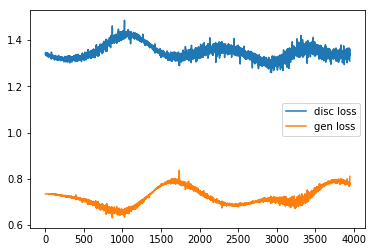

In [14]:
fig, ax = plt.subplots()
plt.plot(D_losses, label="disc loss")
plt.plot(G_losses, label="gen loss")
plt.legend()

In [15]:
def get_pdf(samples, num_bins=30):
    hist, bin_edges = np.histogram(samples, bins=num_bins)
    x = bin_edges[:-1] + np.diff(bin_edges)/2
    P = hist / len(samples)
    return x,  P / (x[1]-x[0])

In [16]:
xdata, pdata = get_pdf(samples)
xdense = np.linspace(np.min(xdata), np.max(xdata), 1000)

In [17]:
true_pdf = lambda x: np.exp( -(x-mu)**2/ (2*sig**2))/np.sqrt(2 * np.pi * sig**2)

In [18]:
xg, pg = [], []

In [19]:
for i in range(epochs):
    x, p = get_pdf(gen_samples[i])
    xg.append(x)
    pg.append(p)

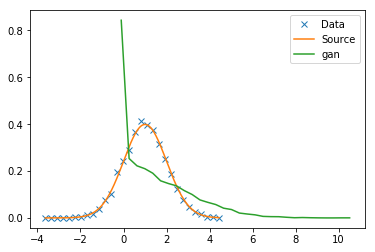

In [20]:
plt.plot(xdata,pdata, label="Data", linestyle='none', marker='x')
plt.plot(xdense, true_pdf(xdense), label="Source")
plt.plot(xg[-1], pg[-1], label="gan")
plt.legend()

In [21]:
from matplotlib.cm import get_cmap

In [22]:
cmap = get_cmap('Reds')
colors = [cmap(i/epochs) for i in range(epochs)]

(0, 1)

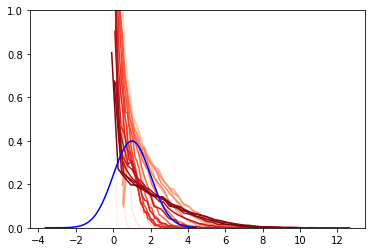

In [23]:
fig, ax = plt.subplots()
for i in range(0,epochs,2):
    plt.plot(xg[i], pg[i], color=colors[i])
plt.plot(xdense, true_pdf(xdense), color='b')
ax.set_ylim([0,1])